In [26]:
from pydriveless import SearchFrame, angle
from ensemble import PhysicalParameters
import numpy as np
import cv2
import matplotlib.pyplot as plt



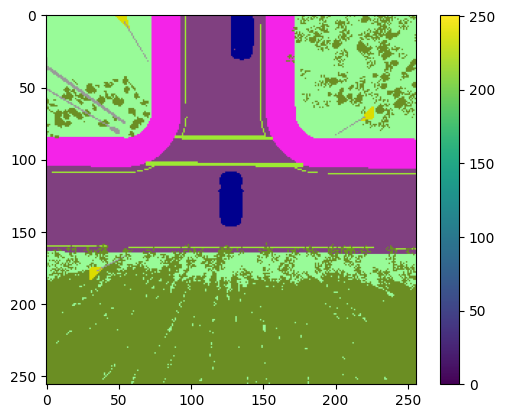

In [27]:
img = np.array(cv2.imread("bev_1.png"), dtype=np.float32)

frame = SearchFrame (
    width=img.shape[1],
    height=img.shape[0],
    lower_bound=PhysicalParameters.EGO_LOWER_BOUND,
    upper_bound=PhysicalParameters.EGO_UPPER_BOUND)
    
frame.set_class_costs(PhysicalParameters.SEGMENTATION_CLASS_COST)
frame.set_class_colors(PhysicalParameters.SEGMENTED_COLORS)
frame.set_frame_data(img)

plt.imshow(frame.get_color_frame())
plt.colorbar()
plt.show()


Preprocessing of Search Space for Collision

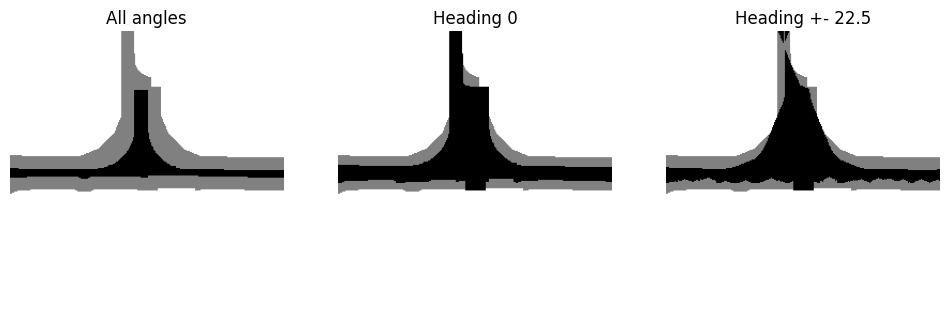

In [28]:
frame.process_safe_distance_zone((PhysicalParameters.MIN_DISTANCE_WIDTH_PX, PhysicalParameters.MIN_DISTANCE_HEIGHT_PX), True)
frame.process_distance_to_goal(107, 0)

f = frame.get_frame()
fp_all = np.zeros(f.shape, dtype=np.uint8)
fp_zero = np.zeros(f.shape, dtype=np.uint8)
fp_22 = np.zeros(f.shape, dtype=np.uint8)

for z in range(f.shape[0]):
    for x in range(f.shape[1]):
        if int(f[z, x, 2]) == 0x00:
            fp_all[z, x, :] = [255, 255, 255]
            fp_zero[z, x, :] = [255, 255, 255]
            fp_22[z, x, :] = [255, 255, 255]
            continue
        if (int(f[z, x, 2]) & 0x04) <= 0 and (int(f[z, x, 2]) & 0x10) <= 0:
            fp_22[z, x, :] = [128, 128, 128]

        if (int(f[z, x, 2]) & 0x08) <= 0:
            fp_zero[z, x, :] = [128, 128, 128]
                        
        if (int(f[z, x, 2]) & 0x100) <= 0:
            fp_all[z, x, :] = [128, 128, 128]
            


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(fp_all)
axes[0].set_title("All angles")
axes[0].axis("off")

axes[1].imshow(fp_zero)
axes[1].set_title("Heading 0")
axes[1].axis("off")

axes[2].imshow(fp_22)
axes[2].set_title("Heading +- 22.5")
axes[2].axis("off")

plt.show()


checkDirectConnectionToGoal: minDistX, minDistZ = 11, 20
[CUDA] 128,128 connects to 107,0,, goal 107, 0
True


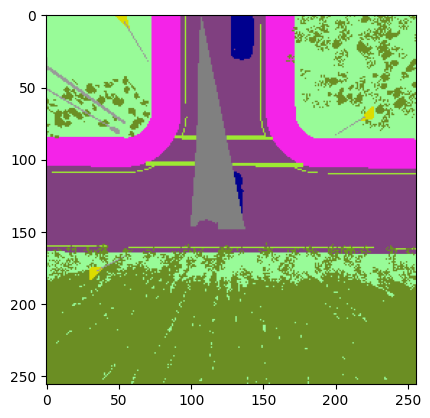

In [29]:
from pyfastrrt import CudaGraph

graph = CudaGraph(
    width=img.shape[1],
    height=img.shape[0],
    perception_width_m=PhysicalParameters.OG_REAL_WIDTH,
    perception_height_m=PhysicalParameters.OG_REAL_HEIGHT,
    lower_bound_x=PhysicalParameters.EGO_LOWER_BOUND[0],
    lower_bound_z=PhysicalParameters.EGO_LOWER_BOUND[1],
    upper_bound_x=PhysicalParameters.EGO_UPPER_BOUND[0],
    upper_bound_z=PhysicalParameters.EGO_UPPER_BOUND[1],
    max_steering_angle_deg=PhysicalParameters.MAX_STEERING_ANGLE,
    vehicle_length_m=PhysicalParameters.VEHICLE_LENGTH_M,
    path_costs=PhysicalParameters.SEGMENTATION_CLASS_COST,
    min_dist_x=PhysicalParameters.MIN_DISTANCE_WIDTH_PX,
    min_dist_z=PhysicalParameters.MIN_DISTANCE_HEIGHT_PX,
)

graph.add(128, 128, angle.new_rad(0), -1, -1, 0)

graph.process_direct_goal_connection(frame, 107, 0, angle.new_deg(0), max_curvature=0.8)

#f = np.zeros(shape=(frame.height(), frame.width(), 3), dtype=np.uint8)
f = frame.get_color_frame()
for z in range(frame.height()):
    for x in range(frame.width()):
        if graph.is_directly_connected_to_goal(x, z):
            f[z, x, :] = [128, 128, 128]

plt.imshow(f)
        

print( graph.is_directly_connected_to_goal(128, 128))

Node (128, 107) is directly connected to goal with heading = -11.10 deg and cost = 108.00


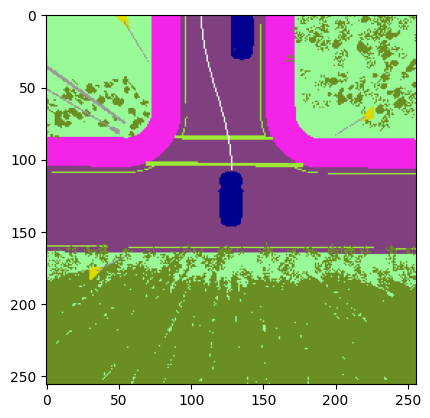

In [33]:
node = (128, 107, 0.0)
goal = (107, 0, 0.0)


from hermite import HermiteCurve

points = HermiteCurve.interpolate(
    width=frame.width(), 
    height=frame.height(),
    p1=node,
    p2=goal,
    max_curvature=0.26)

f = frame.get_color_frame()

for p in points:
    f[p[1], p[0]] = [255, 255, 255]

plt.imshow(f)

if (graph.is_directly_connected_to_goal(node[0], node[1])):
    heading = graph.direct_connection_to_goal_heading(node[0], node[1])
    cost = graph.direct_connection_to_goal_cost(node[0], node[1])
    print(f"Node {node[0], node[1]} is directly connected to goal with heading = {heading.deg():.2f} deg and cost = {cost:.2f}")
else:
    print(f"Node {node[0], node[1]} is NOT directly connected to goal")